In [1]:
# %pip install -U lightgbm==3.3.2

In [11]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import pickle
from tqdm import tqdm
import gc
from pathlib import Path

In [12]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings("ignore")
sys.path.append("../") # path to the `src`` folder
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [13]:
from src.data import DataHelper
from src.data.metrics import map_at_k, hr_at_k, recall_at_k

from src.retrieval.rules import (
    OrderHistory,
    OrderHistoryDecay,
    ItemPair,
    UserGroupTimeHistory,
    UserGroupSaleTrend,
    TimeHistory,
    TimeHistoryDecay,
    SaleTrend,
    OutOfStock,
)
from src.retrieval.collector import RuleCollector

from src.features import cum_sale, week_sale, repurchase_ratio, purchased_before, popularity, period_sale

from src.utils import (
    calc_valid_date,
    merge_week_data,
    reduce_mem_usage,
    calc_embd_similarity,
)

In [14]:
data_dir = Path("../data/")
model_dir = Path("../models/")

In [15]:
TRAIN_WEEK_NUM = 4
WEEK_NUM = TRAIN_WEEK_NUM + 2

VERSION_NAME = "pivot_new"
TEST = True # * Set as `False` when do local experiments to save time

In [16]:
import os
if not os.path.exists(data_dir/"interim"/VERSION_NAME):
    os.mkdir(data_dir/"interim"/VERSION_NAME)
if not os.path.exists(data_dir/"processed"/VERSION_NAME):
    os.mkdir(data_dir/"processed"/VERSION_NAME)

Pepare data: encoding ids and preprocessing

In [17]:
dh = DataHelper(data_dir)

In [18]:
# data = dh.preprocess_data(save=True, name="encoded_full") # * run only once, processed data will be saved

In [19]:
data = dh.load_data(name="encoded_full")

In [20]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

## Retrieval


Generate candidates for each week

In [16]:
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
data['user']['age_bins'] = pd.cut(data['user']['age'], listBin)

In [17]:
# * WEEK_NUM = 0: test
# * WEEK_NUM = 1: valid
# * WEEK_NUM > 1: train
for week in range(1,WEEK_NUM):
    # * use sliding window to generate candidates
    if week == 0 and not TEST:
        continue
    trans = data["df"]

    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")
    
    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

    last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
    last_week_start = last_week_start.strftime("%Y-%m-%d")
    last_week = train.loc[train.t_dat >= last_week_start]
    
    last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
    last_3day_start = last_3day_start.strftime("%Y-%m-%d")
    last_3days = train.loc[train.t_dat >= last_3day_start]

    if week != 0:
        customer_list = valid["customer_id"].values
    else:
        customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            OrderHistory(train, days=3, name='1'),
            OrderHistory(train, days=7, name='2'),
            OrderHistoryDecay(train, days=3, n=50, name='1'),
            OrderHistoryDecay(train, days=7, n=50, name='2'),
            ItemPair(OrderHistory(train, days=3).retrieve(), name='1'),
            ItemPair(OrderHistory(train, days=7).retrieve(), name='2'),
            ItemPair(OrderHistoryDecay(train, days=3, n=50).retrieve(), name='3'),
            ItemPair(OrderHistoryDecay(train, days=7, n=50).retrieve(), name='4'),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50, name='1'),
            UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50, name='2'),
            UserGroupSaleTrend(data, customer_list, train, ['age_bins'], days=7, n=50),
            TimeHistory(customer_list, last_week, n=50, name='1'),
            TimeHistory(customer_list, last_3days, n=50, name='2'),
            TimeHistoryDecay(customer_list, train, days=3, n=50, name='1'),
            TimeHistoryDecay(customer_list, train, days=7, n=50, name='2'),
            SaleTrend(customer_list, train, days=7, n=50),
        ],
        filters=[OutOfStock(trans)],
        min_pos_rate=0.006,
        compress=False,
    )

    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
    )

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

Week 1: [2020-09-16, 2020-09-23)


Retrieve items by rules:   6%|▋         | 1/16 [00:16<04:13, 16.88s/it]

Positive rate: 0.03038


Retrieve items by rules:  12%|█▎        | 2/16 [00:34<04:01, 17.27s/it]

Positive rate: 0.02859


Retrieve items by rules:  19%|█▉        | 3/16 [01:23<06:52, 31.71s/it]

Positive rate: 0.01413


Retrieve items by rules:  25%|██▌       | 4/16 [02:13<07:50, 39.20s/it]

Positive rate: 0.01295


Retrieve items by rules:  31%|███▏      | 5/16 [02:30<05:41, 31.05s/it]

Positive rate: 0.01519
Positive rate: 0.01472


Retrieve items by rules:  38%|███▊      | 6/16 [02:48<04:26, 26.70s/it]

Positive rate: 0.00908


Retrieve items by rules:  44%|████▍     | 7/16 [03:15<03:59, 26.65s/it]

Positive rate: 0.00853


Retrieve items by rules:  50%|█████     | 8/16 [03:50<03:54, 29.30s/it]

TOP15.0 Positive rate: 0.00602


Retrieve items by rules:  56%|█████▋    | 9/16 [03:56<02:34, 22.13s/it]

TOP20.5 Positive rate: 0.00608


Retrieve items by rules:  62%|██████▎   | 10/16 [04:02<01:41, 16.99s/it]

TOP2.0 Positive rate: 0.00652


Retrieve items by rules:  69%|██████▉   | 11/16 [04:13<01:16, 15.28s/it]

TOP9.0 Positive rate: 0.00631


Retrieve items by rules:  75%|███████▌  | 12/16 [04:18<00:48, 12.25s/it]

TOP16.0 Positive rate: 0.00601


Retrieve items by rules:  81%|████████▏ | 13/16 [04:24<00:30, 10.23s/it]

TOP12.0 Positive rate: 0.00607


Retrieve items by rules:  88%|████████▊ | 14/16 [04:51<00:30, 15.41s/it]

TOP8.0 Positive rate: 0.00616


Retrieve items by rules:  94%|█████████▍| 15/16 [05:18<00:18, 18.83s/it]

TOP2.0 Positive rate: 0.00758


Retrieve items by rules: 100%|██████████| 16/16 [05:28<00:00, 20.56s/it]


Week 2: [2020-09-09, 2020-09-16)


Retrieve items by rules:   6%|▋         | 1/16 [00:17<04:22, 17.53s/it]

Positive rate: 0.03008


Retrieve items by rules:  12%|█▎        | 2/16 [00:34<04:04, 17.49s/it]

Positive rate: 0.02825


Retrieve items by rules:  19%|█▉        | 3/16 [01:25<07:01, 32.42s/it]

Positive rate: 0.01354


Retrieve items by rules:  25%|██▌       | 4/16 [02:14<07:47, 38.92s/it]

Positive rate: 0.01244


Retrieve items by rules:  31%|███▏      | 5/16 [02:28<05:32, 30.23s/it]

Positive rate: 0.01435
Positive rate: 0.01376


Retrieve items by rules:  38%|███▊      | 6/16 [02:46<04:19, 25.91s/it]

Positive rate: 0.00886


Retrieve items by rules:  44%|████▍     | 7/16 [03:14<03:58, 26.55s/it]

Positive rate: 0.00830


Retrieve items by rules:  50%|█████     | 8/16 [03:52<04:00, 30.12s/it]

TOP10.0 Positive rate: 0.00610


Retrieve items by rules:  56%|█████▋    | 9/16 [03:58<02:38, 22.68s/it]

TOP7.0 Positive rate: 0.00611


Retrieve items by rules:  69%|██████▉   | 11/16 [04:15<01:17, 15.46s/it]

skip


Retrieve items by rules:  75%|███████▌  | 12/16 [04:19<00:48, 12.24s/it]

skip


Retrieve items by rules:  81%|████████▏ | 13/16 [04:24<00:29,  9.98s/it]

skip
TOP6.0 Positive rate: 0.00606


Retrieve items by rules:  88%|████████▊ | 14/16 [04:50<00:29, 14.90s/it]

TOP7.0 Positive rate: 0.00603


Retrieve items by rules: 100%|██████████| 16/16 [05:25<00:00, 20.33s/it]

skip


Week 3: [2020-09-02, 2020-09-09)


Retrieve items by rules:   6%|▋         | 1/16 [00:17<04:16, 17.10s/it]

Positive rate: 0.02822


Retrieve items by rules:  12%|█▎        | 2/16 [00:34<04:03, 17.39s/it]

Positive rate: 0.02679


Retrieve items by rules:  19%|█▉        | 3/16 [01:23<06:51, 31.67s/it]

Positive rate: 0.01321


Retrieve items by rules:  25%|██▌       | 4/16 [02:12<07:43, 38.60s/it]

Positive rate: 0.01237


Retrieve items by rules:  31%|███▏      | 5/16 [02:28<05:33, 30.29s/it]

Positive rate: 0.01490
Positive rate: 0.01435


Retrieve items by rules:  38%|███▊      | 6/16 [02:44<04:17, 25.72s/it]

Positive rate: 0.00910


Retrieve items by rules:  44%|████▍     | 7/16 [03:16<04:07, 27.54s/it]

Positive rate: 0.00873


Retrieve items by rules:  50%|█████     | 8/16 [03:56<04:13, 31.63s/it]

TOP16.0 Positive rate: 0.00601


Retrieve items by rules:  56%|█████▋    | 9/16 [04:02<02:45, 23.68s/it]

TOP10.5 Positive rate: 0.00612


Retrieve items by rules:  69%|██████▉   | 11/16 [04:19<01:20, 16.03s/it]

skip
TOP11.0 Positive rate: 0.00619


Retrieve items by rules:  75%|███████▌  | 12/16 [04:25<00:51, 12.77s/it]

TOP9.0 Positive rate: 0.00619


Retrieve items by rules:  81%|████████▏ | 13/16 [04:30<00:31, 10.51s/it]

TOP10.0 Positive rate: 0.00601


Retrieve items by rules:  88%|████████▊ | 14/16 [04:56<00:30, 15.12s/it]

TOP9.0 Positive rate: 0.00622


Retrieve items by rules: 100%|██████████| 16/16 [05:30<00:00, 20.66s/it]

skip


Week 4: [2020-08-26, 2020-09-02)


Retrieve items by rules:   6%|▋         | 1/16 [00:16<04:07, 16.52s/it]

Positive rate: 0.02406


Retrieve items by rules:  12%|█▎        | 2/16 [00:34<04:01, 17.24s/it]

Positive rate: 0.02268


Retrieve items by rules:  19%|█▉        | 3/16 [01:23<06:52, 31.71s/it]

Positive rate: 0.01182


Retrieve items by rules:  25%|██▌       | 4/16 [02:12<07:42, 38.53s/it]

Positive rate: 0.01123


Retrieve items by rules:  31%|███▏      | 5/16 [02:27<05:32, 30.22s/it]

Positive rate: 0.01353
Positive rate: 0.01306


Retrieve items by rules:  38%|███▊      | 6/16 [02:45<04:19, 25.95s/it]

Positive rate: 0.00876


Retrieve items by rules:  44%|████▍     | 7/16 [03:21<04:22, 29.21s/it]

Positive rate: 0.00836


Retrieve items by rules:  50%|█████     | 8/16 [04:09<04:41, 35.15s/it]

TOP13.0 Positive rate: 0.00603


Retrieve items by rules:  56%|█████▋    | 9/16 [04:15<03:03, 26.28s/it]

TOP14.5 Positive rate: 0.00606


Retrieve items by rules:  69%|██████▉   | 11/16 [04:34<01:28, 17.62s/it]

skip
TOP5.0 Positive rate: 0.00631


Retrieve items by rules:  75%|███████▌  | 12/16 [04:40<00:56, 14.08s/it]

TOP8.0 Positive rate: 0.00650


Retrieve items by rules:  81%|████████▏ | 13/16 [04:45<00:34, 11.51s/it]

TOP7.0 Positive rate: 0.00607


Retrieve items by rules:  88%|████████▊ | 14/16 [05:12<00:31, 15.99s/it]

TOP3.0 Positive rate: 0.00660


Retrieve items by rules: 100%|██████████| 16/16 [05:46<00:00, 21.65s/it]

skip


Week 5: [2020-08-19, 2020-08-26)


Retrieve items by rules:   6%|▋         | 1/16 [00:16<04:01, 16.11s/it]

Positive rate: 0.02329


Retrieve items by rules:  12%|█▎        | 2/16 [00:32<03:50, 16.45s/it]

Positive rate: 0.02211


Retrieve items by rules:  19%|█▉        | 3/16 [01:18<06:27, 29.79s/it]

Positive rate: 0.01187


Retrieve items by rules:  25%|██▌       | 4/16 [02:05<07:19, 36.62s/it]

Positive rate: 0.01101


Retrieve items by rules:  31%|███▏      | 5/16 [02:20<05:16, 28.79s/it]

Positive rate: 0.01325


Retrieve items by rules:  38%|███▊      | 6/16 [02:37<04:07, 24.73s/it]

Positive rate: 0.01269
Positive rate: 0.00869


Retrieve items by rules:  44%|████▍     | 7/16 [03:11<04:09, 27.76s/it]

Positive rate: 0.00826


Retrieve items by rules:  50%|█████     | 8/16 [03:56<04:26, 33.33s/it]

TOP2.5 Positive rate: 0.00600


Retrieve items by rules:  56%|█████▋    | 9/16 [04:01<02:50, 24.32s/it]

TOP8.0 Positive rate: 0.00605


Retrieve items by rules:  69%|██████▉   | 11/16 [04:16<01:19, 15.83s/it]

skip
TOP2.0 Positive rate: 0.00657


Retrieve items by rules:  81%|████████▏ | 13/16 [04:23<00:29,  9.69s/it]

skip
TOP1.0 Positive rate: 0.00644


Retrieve items by rules:  94%|█████████▍| 15/16 [05:11<00:16, 16.77s/it]

skip


Retrieve items by rules: 100%|██████████| 16/16 [05:20<00:00, 20.01s/it]

skip


In [18]:
# * use the threshold in week 1 to generate candidates for test data, see the log in the upper cell 
if TEST:
    week = 0
    trans = data["df"]
    
    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")
    
    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

    last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
    last_week_start = last_week_start.strftime("%Y-%m-%d")
    last_week = train.loc[train.t_dat >= last_week_start]
    
    last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
    last_3day_start = last_3day_start.strftime("%Y-%m-%d")
    last_3days = train.loc[train.t_dat >= last_3day_start]

    customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            OrderHistory(train, days=3, name='1'),
            OrderHistory(train, days=7, name='2'),
            OrderHistoryDecay(train, days=3, n=50, name='1'),
            OrderHistoryDecay(train, days=7, n=50, name='2'),
            ItemPair(OrderHistory(train, days=3).retrieve(), name='1'),
            ItemPair(OrderHistory(train, days=7).retrieve(), name='2'),
            ItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),
            ItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=15, name='1'),
            UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=20.5, name='2'),
            UserGroupSaleTrend(data, customer_list, train, ['age_bins'], days=7, n=2),
            TimeHistory(customer_list, last_week, n=9, name='1'),
            TimeHistory(customer_list, last_3days, n=16, name='2'),
            TimeHistoryDecay(customer_list, train, days=3, n=12, name='1'),
            TimeHistoryDecay(customer_list, train, days=7, n=8, name='2'),
            SaleTrend(customer_list, train, days=7, n=2),
        ],
        filters=[OutOfStock(trans)],
        min_pos_rate=0.006,
        compress=False,
    )
    
    candidates, _ = reduce_mem_usage(candidates)
    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
    )

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

Week 0: [2020-09-23, 2020-09-30)


Retrieve items by rules: 100%|██████████| 16/16 [05:08<00:00, 19.27s/it]


In [19]:
del train, valid, last_week, customer_list, candidates
gc.collect()

41

## Feature engineering


In [11]:
user = data["user"]
item = data["item"]
inter = data["inter"]

In [12]:
# merge `product_code`
inter = inter.merge(item[["article_id", "product_code"]], on="article_id", how="left")
# calculate week number
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7

In [13]:
inter = inter.sort_values(["t_dat"]).reset_index(drop=True)

In [ ]:
for week in tqdm(range(WEEK_NUM)):
    if week == 0 and not TEST:
        continue

    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")

    week += 1
    df = (
        inter[inter["week"] == week]
        .sort_values(by=["t_dat", "customer_id"])
        .reset_index(drop=True)
        .groupby(["week", "article_id"], as_index=False)
        .last()
        .drop(columns=["customer_id"])
    )

    trans_data = inter[inter['week']>=week]

    # * Repurchase Ratios
    df['i_repurchase_ratio'] = repurchase_ratio(trans_data, df, ['article_id'])
    df['p_repurchase_ratio'] = repurchase_ratio(trans_data, df, ['product_code'])

    # * Sale features
    df["i_sale"]        = week_sale(trans_data, df, ["article_id"])
    df["p_sale"]        = week_sale(trans_data, df, ["product_code"])
    df["i_sale_uni"]    = week_sale(trans_data, df, ["article_id"], True)
    df["p_sale_uni"]    = week_sale(trans_data, df, ["product_code"], True)
    df["lw_i_sale"]     = week_sale(trans_data, df, ["article_id"], step=1) # * last week sale
    df["lw_p_sale"]     = week_sale(trans_data, df, ["product_code"], step=1)
    df["lw_i_sale_uni"] = week_sale(trans_data, df, ["article_id"], True, step=1)
    df["lw_p_sale_uni"] = week_sale(trans_data, df, ["product_code"], True, step=1)

    df["i_sale_ratio"]        = df["i_sale"] / df["p_sale"]
    df["i_sale_uni_ratio"]    = df["i_sale_uni"] / df["p_sale_uni"]
    df["lw_i_sale_ratio"]     = df["lw_i_sale"] / (df["lw_p_sale"] + 1)
    df["lw_i_sale_uni_ratio"] = df["lw_i_sale_uni"] / (df["lw_p_sale_uni"] + 1)

    df["i_uni_ratio"]    = df["i_sale"] / df["i_sale_uni"]
    df["p_uni_ratio"]    = df["p_sale"] / df["p_sale_uni"]
    df["lw_i_uni_ratio"] = df["lw_i_sale"] / (df["lw_i_sale_uni"] + 1)
    df["lw_p_uni_ratio"] = df["lw_p_sale"] / (df["lw_p_sale_uni"] + 1)

    df["i_sale_trend"] = (df["i_sale"] - df["lw_i_sale"]) / (df["lw_i_sale"]+1)
    df["p_sale_trend"] = (df["p_sale"] - df["lw_p_sale"]) / (df["lw_p_sale"]+1)

    item_feats = [
        "product_type_no",
        "product_group_name",
        "graphical_appearance_no",
        "colour_group_code",
        "perceived_colour_value_id",
        "perceived_colour_master_id"
    ]
    trans_data = trans_data.merge(item[["article_id", *item_feats]], on="article_id", how="left")
    df = df.merge(item[["article_id", *item_feats]], on="article_id", how="left")
    for f in item_feats:
        df[f"{f}_sale"]       = week_sale(trans_data, df, [f], f"{f}_sale")
        df[f"lw_{f}_sale"]    = week_sale(trans_data, df, [f], f"{f}_sale", step=1)
        df[f"{f}_sale_trend"] = (df[f"{f}_sale"] - df[f"lw_{f}_sale"]) / (df[f"lw_{f}_sale"] + 1e-6)
    
    # * Period Sale Amount, Rank, Normed Amount
    _, df["i_1w_sale_rank"], df["i_1w_sale_norm"] = period_sale(trans_data, df, ["article_id"], week_no=week, days=14)
    _, df["p_1w_sale_rank"], df["p_1w_sale_norm"] = period_sale(trans_data, df, ["product_code"], week_no=week, days=14)
    df["i_2w_sale"], df["i_2w_sale_rank"], df["i_2w_sale_norm"] = period_sale(trans_data, df, ["article_id"], week_no=week, days=14)
    df["p_2w_sale"], df["p_2w_sale_rank"], df["p_2w_sale_norm"] = period_sale(trans_data, df, ["product_code"], week_no=week, days=14)
    df["i_3w_sale"], df["i_3w_sale_rank"], df["i_3w_sale_norm"] = period_sale(trans_data, df, ["article_id"], week_no=week, days=21)
    df["p_3w_sale"], df["p_3w_sale_rank"], df["p_3w_sale_norm"] = period_sale(trans_data, df, ["product_code"], week_no=week, days=21)
    df["i_4w_sale"], df["i_4w_sale_rank"], df["i_4w_sale_norm"] = period_sale(trans_data, df, ["article_id"], week_no=week, days=28)
    df["p_4w_sale"], df["p_4w_sale_rank"], df["p_4w_sale_norm"] = period_sale(trans_data, df, ["product_code"], week_no=week, days=28)

    # * Popularity
    df['i_pop'] = popularity(trans_data, df, 'article_id')
    df['p_pop'] = popularity(trans_data, df, 'product_code')

    # * Date related
    curr_date_dict = {x:calc_valid_date(x-1)[0] for x in range(1, WEEK_NUM+1)}
    current_dat = df['week'].map(curr_date_dict)
    first_date = trans_data.groupby('article_id')['t_dat'].min().reset_index(name='first_dat')
    last_date = trans_data.groupby('article_id')['t_dat'].max().reset_index(name='last_dat')
    df = pd.merge(df, first_date, on='article_id', how='left')
    df = pd.merge(df, last_date, on='article_id', how='left')
    df['first_dat'] = (pd.to_datetime(current_dat)-pd.to_datetime(df['first_dat'])).dt.days
    df['last_dat'] = (pd.to_datetime(current_dat)-pd.to_datetime(df['last_dat'])).dt.days

    i_full_sale = trans_data.groupby('article_id').size().reset_index(name='i_full_sale')
    p_full_sale = trans_data.groupby('product_code').size().reset_index(name='p_full_sale')
    df = df.merge(i_full_sale, on='article_id', how='left')
    df = df.merge(p_full_sale, on='product_code', how='left')

    df['i_daily_sale'] = df['i_full_sale'] / df['first_dat']
    df['p_daily_sale'] = df['p_full_sale'] / df['first_dat']
    df['i_daily_sale_ratio'] = df['i_daily_sale'] / df['p_daily_sale']
    df['i_w_full_sale_ratio'] = df['i_sale'] / df['i_full_sale']
    df['i_2w_full_sale_ratio'] = df['i_2w_sale'] / df['i_full_sale']
    df['p_w_full_sale_ratio'] = df['p_sale'] / df['p_full_sale']
    df['p_2w_full_sale_ratio'] = df['p_2w_sale'] / df['p_full_sale']

    df['i_week_above_daily_sale'] = df['i_sale'] / 7 - df['i_daily_sale']
    df['p_week_above_full_sale'] = df['p_sale'] / 7 - df['i_full_sale']
    df['i_2w_week_above_daily_sale'] = df['i_2w_sale'] / 14 - df['i_daily_sale']
    df['p_2w_week_above_daily_sale'] = df['p_2w_sale'] / 14 - df['p_daily_sale']

    for f in item_feats:
        f_full_sale = trans_data.groupby(f).size().reset_index(name=f'{f}_full_sale')
        f_first_date = trans_data.groupby(f)['t_dat'].min().reset_index(name=f'{f}_first_dat')
        df = df.merge(f_full_sale, on=f, how='left')
        df = df.merge(f_first_date, on=f, how='left')
        df[f'{f}_daily_sale'] = df[f'{f}_full_sale'] / (pd.to_datetime(current_dat) - pd.to_datetime(df[f'{f}_first_dat'])).dt.days
        df[f'i_{f}_daily_sale_ratio'] = df['i_daily_sale'] / df[f'{f}_daily_sale']
        df[f'p_{f}_daily_sale_ratio'] = df['p_daily_sale'] / df[f'{f}_daily_sale']
        df.drop([f'{f}_full_sale'], axis=1, inplace=True)

    
    df = df.drop(columns=item_feats+['i_full_sale','p_full_sale'])
    trans_data = trans_data.drop(columns=item_feats)

    df["week"] -= 1 # * target candidate week to be merged with
    df.to_parquet(data_dir / f"processed/week_{week-1}_processed_inter.pqt")
    print(df.isna().any().sum())

In [19]:
# inter["purchased_item"] = purchased_before(inter, ["article_id"])
# inter["purchased_pro"] = purchased_before(inter, ["product_code"])

## Merge Features


In [21]:
# inter = pd.read_parquet(data_dir / "processed/processed_inter.pqt")
# inter = inter[inter['week'] <= WEEK_NUM + 2]
# data["inter"] = inter

In [22]:
#* embeddings from DSSM model
dssm_user_embd = np.load(data_dir / "external/dssm_user_embd.npy", allow_pickle=True)
dssm_item_embd = np.load(data_dir / "external/dssm_item_embd.npy", allow_pickle=True)
# * embeddings from YouTubeDNN model
yt_user_embd = np.load(data_dir / "external/yt_user_embd.npy", allow_pickle=True)
yt_item_embd = np.load(data_dir / "external/yt_item_embd.npy", allow_pickle=True)

In [ ]:
for i in tqdm(range(WEEK_NUM)):
    if i == 0 and not TEST:
        continue
    
    candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
    inter_info = pd.read_parquet(data_dir / f"processed/week_{i}_processed_inter.pqt")
#     inter_info[inter_info.columns] = np.nan_to_num(inter_info.values)
    if i == 0:
        chunk_size = int(candidate.shape[0] * 0.5)
        tmpl = []
        for batch in range(0, candidate.shape[0], chunk_size):
            sub_candidate = candidate.iloc[batch:batch+chunk_size-1]

            gc.collect()
            # * merge features
            sub_candidate = merge_week_data(data, inter_info, i, sub_candidate)
            sub_candidate['article_id'] = sub_candidate['article_id'].astype(int)
            sub_candidate['customer_id'] = sub_candidate['customer_id'].astype(int)
            # * merge DSSM user and item embeddings
            sub_candidate["dssm_similarity"] = calc_embd_similarity(sub_candidate, dssm_user_embd, dssm_item_embd)
            # * merge YouTubeDNN user and item embeddings
            sub_candidate["yt_similarity"] = calc_embd_similarity(sub_candidate, yt_user_embd, yt_item_embd)
            print(f"Chunk {batch} done...")
            tmpl.append(sub_candidate)
        
        candidate = pd.concat(tmpl, ignore_index=True)
        del tmpl
        gc.collect()
    else:
        # * merge features
        candidate = merge_week_data(data, inter_info, i, candidate)
        candidate['article_id'] = candidate['article_id'].astype(int)
        candidate['customer_id'] = candidate['customer_id'].astype(int)
        # * merge DSSM user and item embeddings
        candidate["dssm_similarity"] = calc_embd_similarity(candidate, dssm_user_embd, dssm_item_embd)
        # * merge YouTubeDNN user and item embeddings
        candidate["yt_similarity"] = calc_embd_similarity(candidate, yt_user_embd, yt_item_embd)

    candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")

In [ ]:
del dssm_user_embd, dssm_item_embd, yt_user_embd, yt_item_embd
gc.collect()

40

## Ranking


In [11]:
candidates = {}
labels = {}
for i in tqdm(range(1, WEEK_NUM)):
    candidates[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")
    labels[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_label.pqt")    

100%|██████████| 5/5 [00:10<00:00,  2.05s/it]


In [12]:
feats = [
    x
    for x in candidates[1].columns
    if x
    not in [
        "label",
        "sales_channel_id",
        "t_dat",
        "week",
    ]
]
cat_features = [
    "customer_id",
    "article_id",
    "product_code",
    "FN",
    "Active",
    "club_member_status",
    "fashion_news_frequency",
    "age",
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",

    "user_gender",
    "article_gender",
    "season_type"
]

In [13]:
# * Convert categorical featues as `CategoricalDtype`
cate_dict = {}        
for feat in tqdm(cat_features):
    if feat in data['user'].columns:
        value_set = set(data['user'][feat].unique())
    elif feat in data['item'].columns:
        value_set = set(data['item'][feat].unique())
    else:
        value_set = set(data['inter'][feat].unique())
    cate_dict[feat] = CategoricalDtype(categories=value_set)

100%|██████████| 17/17 [00:00<00:00, 23.09it/s]


In [14]:
for i in tqdm(range(1,WEEK_NUM)):
    for feat in cat_features:
        candidates[i][feat] = candidates[i][feat].astype(cate_dict[feat])

100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


### Train


In [15]:
params = {
    "objective": "lambdarank",#"lambdarank",
    "boosting_type": "gbdt",
    "metric": "map",#"map",
    "max_depth": 8,
    "num_leaves": 128,
    "learning_rate": 0.03,

    "verbose": -1,
    "eval_at": 12,
    # 'device':'gpu'
}

In [16]:
# * some rules are skipped for some weeks, we need to concat them together
# * to merge the columns
full_data = pd.concat([candidates[i] for i in range(1, WEEK_NUM)], ignore_index=True)

In [17]:
# # New Feature
# first_date = data['inter'].groupby('article_id')['t_dat'].min().reset_index(name='first_dat')
# curr_date_dict = {x:calc_valid_date(x)[0] for x in range(1, WEEK_NUM)}
# current_dat = full_data['week'].map(curr_date_dict)
# full_data = pd.merge(full_data, first_date, on='article_id', how='left')
# full_data['first_dat'] = (pd.to_datetime(current_dat)-pd.to_datetime(full_data['first_dat'])).dt.days

# feats.append('first_dat')

In [18]:
# for f in ["i_sale", "p_sale", "i_sale_uni", "p_sale_uni"]:
#     full_data[f"{f}_day_sale"] = full_data[f] / full_data["first_dat"]
#     feats.append(f"{f}_day_sale")

In [19]:
def train_model(full_data, valid_week_num, train_week_num=4):
    print("Validating week:", valid_week_num)
    train = full_data[
        (valid_week_num < full_data["week"])
        & (full_data["week"] <= valid_week_num + train_week_num)
    ]
    valid = full_data[full_data["week"] == valid_week_num]
    train = train.sort_values(by=["week", "customer_id"], ascending=True).reset_index(
        drop=True
    )
    valid = valid.sort_values(by=["customer_id"], ascending=True).reset_index(drop=True)
    print("Train positive rate:", train.label.mean())  # 0.9946384702188372 4-week

    train_group = train[["customer_id", "article_id", "week"]]
    train_group = train_group.astype(
        "int"
    )  # * convert to int to avoid `0` in groupby count result
    train_group = (
        train_group.groupby(["week", "customer_id"])["article_id"].count().values
    )

    valid_group = valid[["customer_id", "article_id"]]
    valid_group = valid_group.astype(
        "int"
    )  # * convert to int to avoid `0` in groupby count result
    valid_group = valid_group.groupby(["customer_id"])["article_id"].count().values

    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        group=train_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        group=valid_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    ranker.save_model(
        model_dir / f"lgb_ranker_{valid_week_num}.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [20]:
def train_binary_model(full_data, valid_week_num, train_week_num=4):
    print("Validating week:", valid_week_num)
    train = full_data[
        (valid_week_num < full_data["week"])
        & (full_data["week"] <= valid_week_num + train_week_num)
    ]
    valid = full_data[full_data["week"] == valid_week_num]

    print("Train positive rate:", train.label.mean())  # 0.9946384702188372 4-week


    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    ranker.save_model(
        model_dir / f"lgb_ranker_{valid_week_num}.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [21]:
ranker = train_model(full_data, 1, 4) # 4-week 0.853142  0.851841
# ranker = train_binary_model(full_data, 1, 4)# 0.709413

# 0.853642 0.853926

Validating week: 1
Train positive rate: 0.006717196927227722
Training until validation scores don't improve for 30 rounds
[10]	valid_0's map@12: 0.852166
[20]	valid_0's map@12: 0.852078
[30]	valid_0's map@12: 0.852299
[40]	valid_0's map@12: 0.852858
[50]	valid_0's map@12: 0.85304
[60]	valid_0's map@12: 0.853173
[70]	valid_0's map@12: 0.853434
[80]	valid_0's map@12: 0.853293
[90]	valid_0's map@12: 0.853504
[100]	valid_0's map@12: 0.853496
[110]	valid_0's map@12: 0.853648
[120]	valid_0's map@12: 0.853589
[130]	valid_0's map@12: 0.853621
[140]	valid_0's map@12: 0.853555
[150]	valid_0's map@12: 0.853536
Early stopping, best iteration is:
[127]	valid_0's map@12: 0.853688


### Inference

In [22]:
ranker = lgb.Booster(model_file=model_dir / "lgb_ranker_1.model")

<Figure size 576x1584 with 0 Axes>

<AxesSubplot:xlabel='importance', ylabel='feature'>

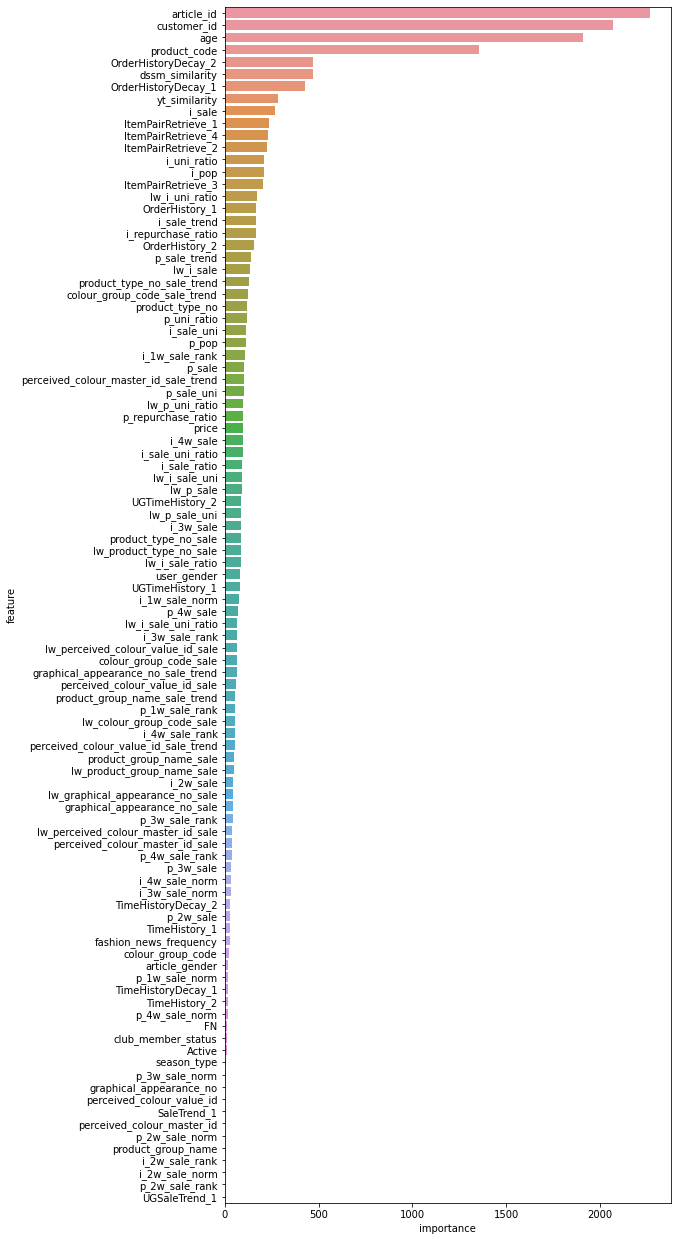

In [23]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 22))
sns.barplot(y="feature", x="importance", data=feat_importance)

### Validate

In [24]:
val_candidates = full_data[full_data["week"] == 1].reset_index(drop=True)

In [25]:
def predict(ranker, candidates, batch_size = 5_000_000):
    probs = np.zeros(candidates.shape[0])
    for batch in range(0, candidates.shape[0], batch_size):
        outputs = ranker.predict(candidates.loc[batch : batch + batch_size - 1, feats])
        probs[batch : batch + batch_size] = outputs
    candidates["prob"] = probs
    pred_lgb = candidates[['customer_id','article_id','prob']]
    pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
    pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
    pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
    pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)
    pred_lgb = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()
    return pred_lgb

In [26]:
pred = predict(ranker, val_candidates)

100%|██████████| 80093/80093 [00:05<00:00, 14730.87it/s]


In [27]:
label = labels[1]
label = pd.merge(label, pred, on="customer_id", how="left")

In [28]:
map_at_k(label["article_id"], label["prediction"], k=12)

# 0.02820525160663368 1-week add normalization
# 0.028936597823123886 4-week min_pos_rate 0.006 0.0274
# 0.029111989281461418 4-week drop full-negative customer
# 0.029165419468984943 3-week 0.0270
# 0.028694388096248934 4-week min_pos_rate 0.005 lr=0.03
# 0.028927037894290773 4-week min_pos_rate 0.005 lr=0.01
# 0.028936597823123886 4-week min_pos_rate 0.005 lr=0.01 max_depth=9, num_leaves=256

# 0.029035548891779315 LB:0.0267+
# 0.02936299322497085 LB:0.0272 binary: 0.02875858467034642

# 0.02934790456627846
# 0.029538123693645727 first_date
# 0.02971730505701681

# 0.029708567511235916

0.029708567511235916

In [36]:
batch_size = 5_000_000
probs = np.zeros(val_candidates.shape[0])
for batch in range(0, val_candidates.shape[0], batch_size):
    outputs = ranker.predict(val_candidates.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs
val_candidates["prob"] = probs
pred_lgb = val_candidates[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)

In [37]:
pred_lgb.to_csv(data_dir/"processed"/"binary_valid.csv", index=False)

---

In [11]:
pred_lgb = pd.read_csv(data_dir/"processed"/"binary_valid.csv")

In [38]:
nn_pred_lgb = pd.read_csv(data_dir/"external"/"nn_valid.csv")
nn_pred_lgb.rename(columns={'prob':'nn_prob','article_id':'prediction'}, inplace=True)

<AxesSubplot:>

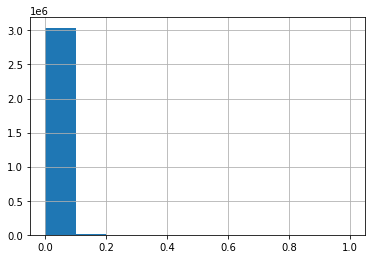

In [39]:
(nn_pred_lgb['nn_prob']).hist()

<AxesSubplot:>

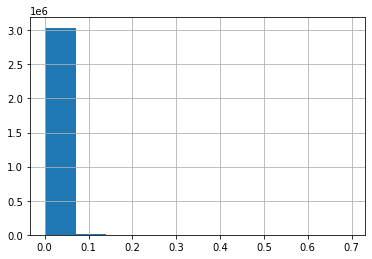

In [40]:
pred_lgb['prob'].hist()

In [41]:
pred_lgb = pred_lgb.merge(nn_pred_lgb, on=["customer_id",'prediction'], how="left")

In [45]:
pred_lgb['score'] = pred_lgb['prob'] + pred_lgb['nn_prob']
pred_lgb = pred_lgb.sort_values(by=["customer_id","score"], ascending=False).reset_index(drop=True)
pred = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()

100%|██████████| 80093/80093 [00:01<00:00, 48610.56it/s]


In [46]:
label = labels[1]
label = pd.merge(label, pred, on="customer_id", how="left")

In [47]:
map_at_k(label["article_id"], label["prediction"], k=12) # 0.03040650316743402

0.03202169212098294

### Test

In [48]:
del full_data, val_candidates, candidates
gc.collect()

60

In [49]:
test_candidates = pd.read_parquet(data_dir/"processed"/VERSION_NAME/"week0_candidate.pqt")
for feat in cat_features:
    test_candidates[feat] = test_candidates[feat].astype(cate_dict[feat])

In [50]:
batch_size = 5_000_000
probs = np.zeros(test_candidates.shape[0])
for batch in range(0, test_candidates.shape[0], batch_size):
    outputs = ranker.predict(test_candidates.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs
test_candidates["prob"] = probs
pred_lgb = test_candidates[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)

In [51]:
pred_lgb.to_csv(data_dir/"processed"/"binary_test.csv", index=False)

---

In [66]:
pred_lgb = pd.read_csv(data_dir/"processed"/"binary_test.csv")

In [67]:
pred_nn = pd.read_csv(data_dir/"processed"/"nn_test.csv")
pred_nn.rename(columns={'prob':'nn_prob','article_id':'prediction'}, inplace=True)

In [68]:
pred_lgb = pred_lgb.merge(pred_nn, on=["customer_id",'prediction'], how="left")

In [69]:
pred_lgb['prob'] = pred_lgb['nn_prob'] # pred_lgb['prob'] + 
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)

In [70]:
pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)

In [71]:
# test_pred = predict(ranker, test_candidates)

In [72]:
test_pred = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()

100%|██████████| 1371980/1371980 [00:29<00:00, 46379.83it/s]


In [73]:
idx2uid = pickle.load(open(data_dir/"index_id_map/user_index2id.pkl", "rb"))
idx2iid = pickle.load(open(data_dir/"index_id_map/item_index2id.pkl", "rb"))

In [74]:
def parse(x):
    l = ['0'+str(idx2iid[i]) for i in x]
    l = ' '.join(l[:12])
    return l

In [75]:
test_pred['prediction'] = test_pred['prediction'].progress_apply(lambda x: parse(x))

100%|██████████| 1371980/1371980 [00:19<00:00, 70487.53it/s]


In [76]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

In [77]:
del submission['prediction']
submission = submission.merge(test_pred, on='customer_id', how='left')
submission['customer_id'] = submission['customer_id'].map(idx2uid)

In [78]:
submission.to_csv('submission.csv', index=False)

In [79]:
submission.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0751471043 0751471001 0673677002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0863583001 0918292001 0714790020 0448509014 05...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0863583001 0805000001 0934835001 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0918292001 0918890002 0866731001 0918522001 08...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0927530004 0896152002 0730683050 0791587015 08...


### Submit

In [46]:
submit_msg = """
0.028927037894290773 4-week drop
---
OrderHistory(train, days=3, name='1'),
OrderHistory(train, days=7, name='2'),
OrderHistoryDecay(train, days=3, n=50, name='1'),
OrderHistoryDecay(train, days=7, n=50, name='2'),
ItemPair(OrderHistory(train, days=3).retrieve(), name='1'),
ItemPair(OrderHistory(train, days=7).retrieve(), name='2'),
ItemPair(OrderHistoryDecay(train, days=3, n=50).retrieve(), name='3'),
ItemPair(OrderHistoryDecay(train, days=7, n=50).retrieve(), name='4'),
UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50, name='1'),
UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50, name='2'),
UserGroupSaleTrend(data, customer_list, train, ['age_bins'], days=7, n=50),
TimeHistory(customer_list, last_week, n=50, name='1'),
TimeHistory(customer_list, last_3days, n=50, name='2'),
TimeHistoryDecay(customer_list, train, days=3, n=50, name='1'),
TimeHistoryDecay(customer_list, train, days=7, n=50, name='2'),
SaleTrend(customer_list, train, days=7, n=50)
---
min_pos_rate = 0.005
pivot
"""

In [47]:
submit_msg

"\n0.029111989281461418 4-week drop full negative user\n---\nOrderHistory(train, 3),\nOrderHistory(train, 7),\nOrderHistoryDecay(train, 3, n=50),\nOrderHistoryDecay(train, 7, n=50),\nItemPair(OrderHistory(train, 3).retrieve(), name='1'),\nItemPair(OrderHistory(train, 7).retrieve(), name='2'),\nItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),\nItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),\nUserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),\nUserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),\nUserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),\nTimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),\nTimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),\nTimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),\nTimeHistoryDecay(customer_list, train, 7, n=50 if w

In [60]:
# ! mkdir ~/.kaggle
# ! cp ../kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [65]:
# %pip install kaggle

     |████████████████████████████████| 58 kB 3.9 MB/s eta 0:00:011
     |████████████████████████████████| 78 kB 5.7 MB/s eta 0:00:011
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=2aaa2ba8e16413cb4c49862167277c1d8f29337d273f3f9b02c7f2a0d2b3a357
  Stored in directory: /root/.cache/pip/wheels/29/da/11/144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
Successfully built kaggle
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [48]:
! kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f ./submission.csv -m '\n0.029111989281461418 4-week drop full negative user\n---\nOrderHistory(train, 3),\nOrderHistory(train, 7),\nOrderHistoryDecay(train, 3, n=50),\nOrderHistoryDecay(train, 7, n=50),\nItemPair(OrderHistory(train, 3).retrieve(), name='1'),\nItemPair(OrderHistory(train, 7).retrieve(), name='2'),\nItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),\nItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),\nUserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),\nUserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),\nUserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),\nTimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),\nTimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),\nTimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),\nTimeHistoryDecay(customer_list, train, 7, n=50 if week!=0 else 8),\nSaleTrend(customer_list, train, 7, n=50 if week!=0 else 2)\n---\nmin_pos_rate = 0.006\npivot\n'

100%|████████████████████████████████████████| 258M/258M [00:11<00:00, 22.7MB/s]
Successfully submitted to H&M Personalized Fashion Recommendations